# Merging both dataframes, features from songs and features from lyrics

In [ ]:
import pandas as pd
import numpy as np
from Funciones import limpieza
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
df_final = pd.read_csv('df_final.csv')

In [ ]:
df_final.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'release_year', 'idioma',
       'lyrics', 'artist_popularity', 'track_album_release_month',
       'clean_lyrics', 'len_words', 'riq_lex', 'most1', 'most1_freq', 'most2',
       'most2_freq', 'most3', 'most3_freq', 'less1', 'less1_freq', 'less2',
       'less2_freq', 'less3', 'less3_freq', 'len_ws', 'riq_lex_ws',
       'MostFreqPercentage', 'explicit', 'non_explicit', 'has_intro',
       'has_outro', 'chorus_count', 'prechorus_count', 'verse_count',
       'coef_chorus/len', 'verse_chorus/len', 'len_estribillo_clean', 'topic1',
       'topic2', 'topic3'],
      dtype='object')

In [ ]:
df_final.drop(columns=['most2', 'most2_freq', 'most3', 'most3_freq', 'less1', 'less1_freq', 'less2', 'less2_freq', 'less3', 'less3_freq'], inplace=True)

In [ ]:
df_final['most1'] = df_final['most1'].astype('string')

In [ ]:
len(df_final)

7637

## We delete columns that we don't need for modeling

In [ ]:
df_final.drop(columns=['track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id', 'idioma', 'lyrics', 'clean_lyrics'], inplace=True)

In [ ]:
df_final.columns

Index(['track_popularity', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'release_year', 'artist_popularity',
       'track_album_release_month', 'len_words', 'riq_lex', 'most1',
       'most1_freq', 'len_ws', 'riq_lex_ws', 'MostFreqPercentage', 'explicit',
       'non_explicit', 'has_intro', 'has_outro', 'chorus_count',
       'prechorus_count', 'verse_count', 'coef_chorus/len', 'verse_chorus/len',
       'len_estribillo_clean', 'topic1', 'topic2', 'topic3'],
      dtype='object')

We plot the new features, seing its relation with track_popularity

c:\Users\silvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\silvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\silvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\silvi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

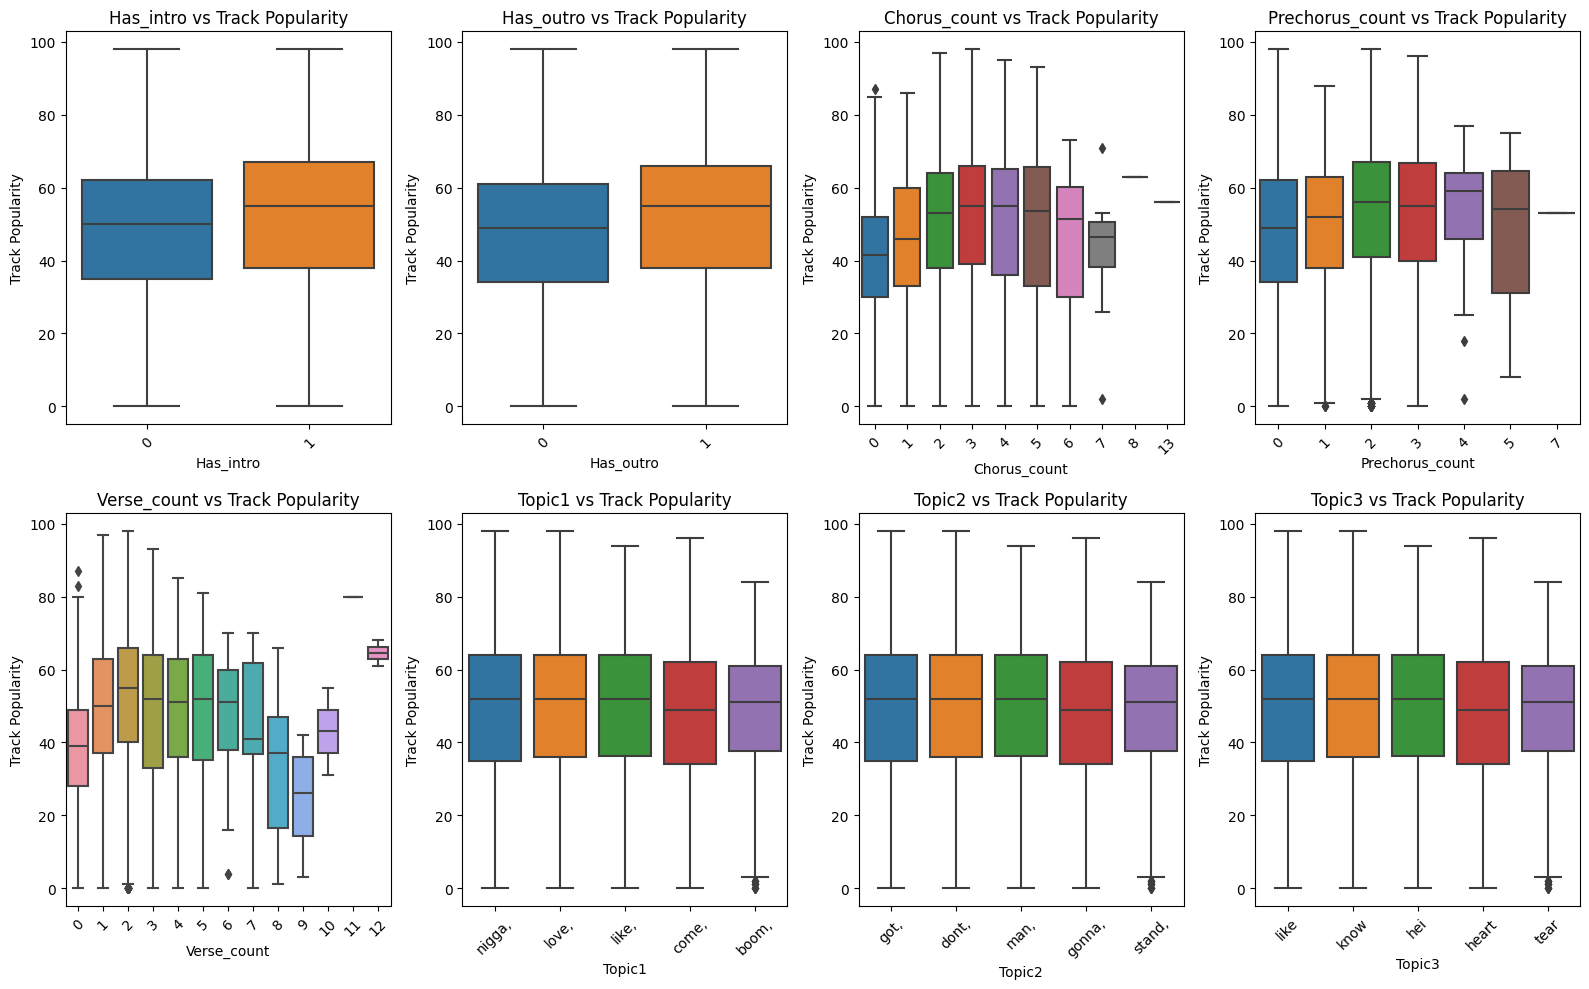

In [ ]:
# Categorical features
categorical_features = ['has_intro', 'has_outro', 'chorus_count', 'prechorus_count', 'verse_count', 'topic1', 'topic2', 'topic3']

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

# Loop through each categorical feature and create box plots
for i, feature in enumerate(categorical_features):
    row = i // 4  # Calculate row index
    col = i % 4   # Calculate column index
    sns.boxplot(x=feature, y='track_popularity', data=df_final, ax=axes[row, col])
    axes[row, col].set_title(f'{feature.capitalize()} vs Track Popularity')
    axes[row, col].set_xlabel(feature.capitalize())
    axes[row, col].set_ylabel('Track Popularity')
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability if needed

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Since the distributions of intro and outro are pretty simmilar in relation with the track_popularity, we will not consider them

In [ ]:
df_final.drop(columns=['has_intro', 'has_outro'], inplace=True)

In [ ]:
num_col = ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

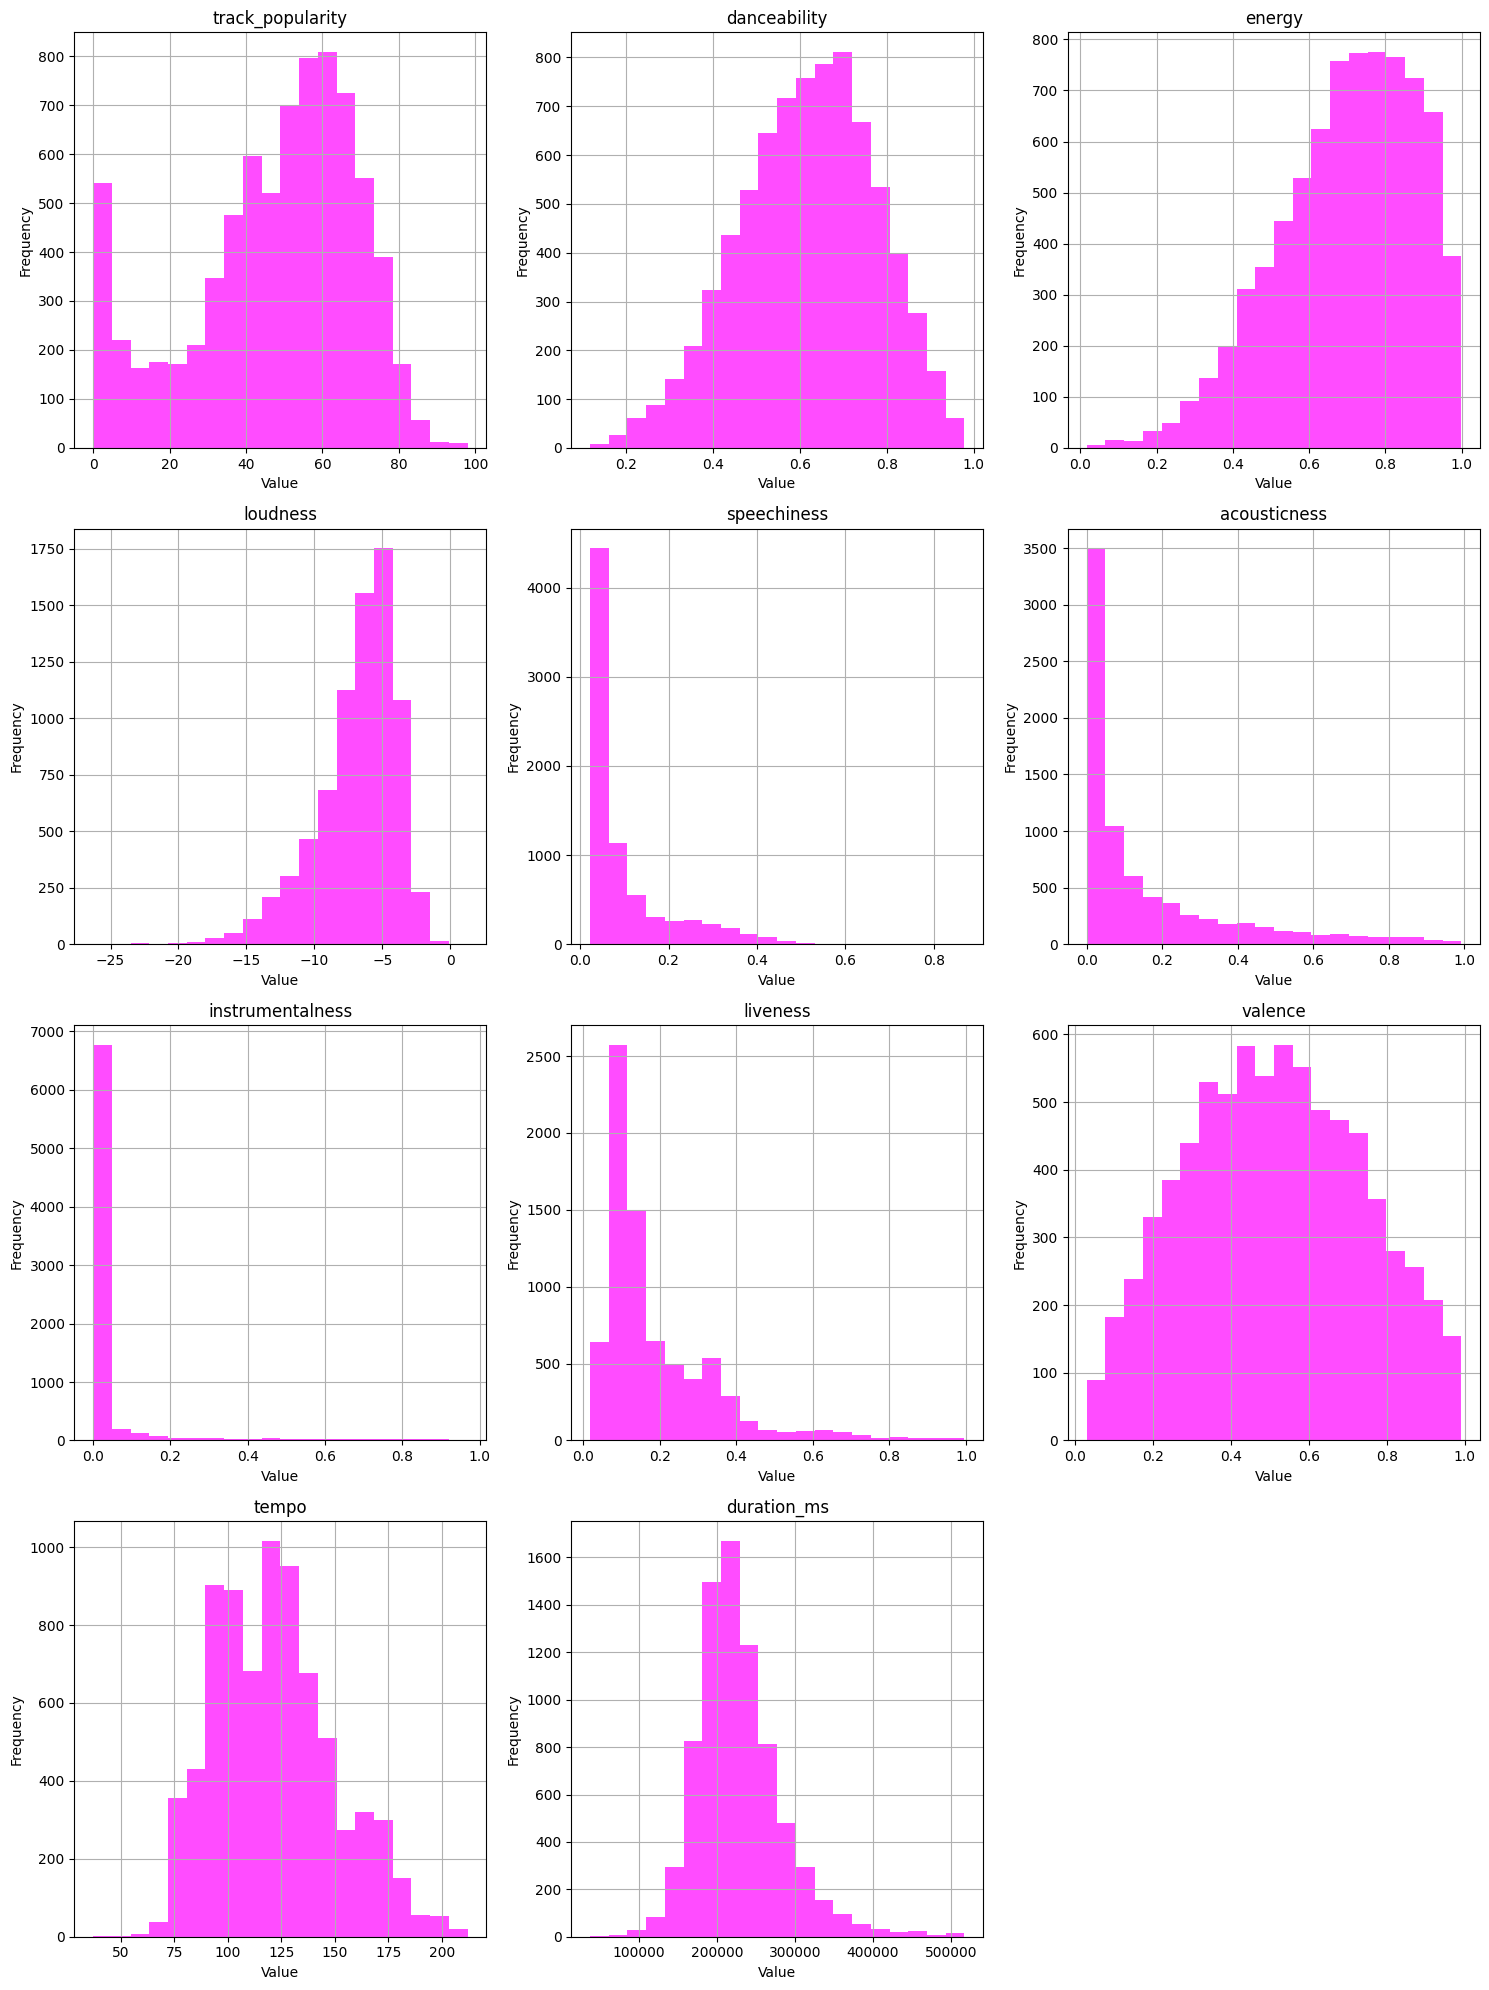

In [ ]:
num_plots = len(num_col)
num_rows = (num_plots - 1) // 3 + 1  # Calculate the number of rows needed for plots

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))

# Flatten axes if necessary (in case there's only one row)
if num_rows == 1:
    axes = axes[np.newaxis, :]

for i, column in enumerate(num_col):
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    ax = axes[row, col]
    ax.hist(df[column], bins=20, alpha=0.7, color='magenta')
    ax.set_title(column)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    ax.grid(True)

# Hide empty subplots, if any
if num_plots < num_rows * 3:
    for i in range(num_plots, num_rows * 3):
        axes[num_rows - 1, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def dummies(x):
    x = pd.get_dummies(x, drop_first=True, dtype=int)
    return x

def esc_log(x):
    variables =['speechiness', 'liveness']  #'energy'
    for i in variables:
        x.loc[:,i] = np.log(x[i])

def esc_sq(x):
    variables =['acousticness']
    for i in variables:
        x.loc[:,i] = np.sqrt(x[i])

In [ ]:
def transformacion(x):
    esc_log(x)
    esc_sq(x)
    x = dummies(x)
    return x

In [ ]:
df_final = transformacion(df_final)

In [ ]:
pd.set_option('display.max_columns', None)
df_final

track_popularity  danceability  energy  key  loudness  mode  \
0                   48         0.552   0.842    8    -4.961     1   
1                   55         0.681   0.567    8    -7.353     1   
2                   68         0.893   0.839   11    -6.785     1   
3                   27         0.722   0.635    1    -6.211     1   
4                   69         0.645   0.675    1    -5.282     0   
...                ...           ...     ...  ...       ...   ...   
7632                 0         0.698   0.238   11   -15.549     1   
7633                 0         0.493   0.946    0    -2.169     1   
7634                 0         0.810   0.628   11    -8.279     0   
7635                 0         0.913   0.546    1    -7.525     1   
7636                 0         0.531   0.937    6    -5.932     1   

      speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       -1.255266      0.132665          0.003270 -1.354796    0.561   89.017   
1       -0.962335      0.417133          0.000000 -2.728763    0.698   73.009   
2       -2.701571      0.301828          0.000018 -2.180367    0.801  129.998   
3       -3.134994      0.233024          0.000368 -2.273026    0.364  107.013   
4       -1.599488      0.101980          0.000000 -1.298283    0.171  120.672   
...           ...           ...               ...       ...      ...      ...   
7632    -3.090043      0.900000          0.000000 -2.695628    0.761  149.132   
7633    -2.588935      0.025475          0.000043 -1.313044    0.749  152.089   
7634    -1.280134      0.110454          0.000000 -2.689719    0.710  155.939   
7635    -2.055725      0.327109          0.000000 -1.136314    0.741  102.652   
7636    -3.221379      0.070214          0.000007 -2.002481    0.135  121.986   

      duration_ms  release_year  artist_popularity  track_album_release_month  \
0          281960          2000               63.0                          1   
1          207714          2016               77.0                          6   
2          214155          2019               71.5                          7   
3          203304          2017               13.0                          8   
4          209120          2019               71.0                          7   
...           ...           ...                ...                        ...   
7632       172733          1975               41.0                          1   
7633       187467          2008               76.0                          1   
7634       253507          1990               58.0                          1   
7635       238320          2004               50.0                          1   
7636       339107          2012               30.0                         11   

      len_words   riq_lex  most1_freq  len_ws  riq_lex_ws  MostFreqPercentage  \
0           544  0.344569          20     801    0.344569           13.786765   
1           199  0.342767          51     318    0.342767           54.773869   
2           465  0.358521          19     622    0.358521           15.698925   
3           106  0.430464          12     151    0.430464           25.471698   
4           422  0.399610          19     513    0.399610           12.796209   
...         ...       ...         ...     ...         ...                 ...   
7632        104  0.467066           9     167    0.467066           18.269231   
7633        117  0.342723          11     213    0.342723           27.350427   
7634        433  0.350970          86     567    0.350970           26.789838   
7635        328  0.561475           6     488    0.561475            6.097561   
7636         74  0.752475           5     101    0.752475            6.756757   

      explicit  non_explicit  chorus_count  prechorus_count  verse_count  \
0     0.592541      0.407459             3                0            3   
1     0.528475      0.471525             3                0            2   
2     0.542942      0.457058  

In [ ]:
len(df_final.columns)

1777

### FIRST MODEL WITHOUT LYRICS FEATURES

In [ ]:
X = df_final[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'release_year', 'artist_popularity',
       'track_album_release_month']]
Y = df_final['track_popularity']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=28)

In [ ]:
xgbmodel = XGBRegressor()

In [ ]:
params={'base_score': [0.5], # prediccion inicial
     'booster': ['gbtree','gblinear'], # (gbtree, gblinear, dart)
     'colsample_bylevel': [0.7,1], # ratio de columnas en cada nivel
     'colsample_bytree': [0.7, 1], # ratio de columnas por tree
     'learning_rate': [0.1], # (eta) aportacion de cada arbol al modelo
     'max_depth': [3,4,5,6], # maxima profundidad en cada arbol
     'min_child_weight': [1], # minimo numero samples por hoja
    #'missing': [1], # si queremos reemplazar los missings por un numero
     'n_estimators': [100,250,300,400], # numero de arboles
     'n_jobs': [-1], # trabajos en paralelo
     'random_state': [8], # seed para generar los folds
     'reg_alpha': [0.01, 0.1]} # L1 regularitacion

In [ ]:
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                   param_grid = params,
                   scoring = scoring,
                   cv = 3,
                   n_jobs=-1,
                   refit='neg_mean_squared_error',
                   verbose = 2)

In [ ]:
model_result_xgboost = grid_solver.fit(x_train,y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


In [ ]:
model_result_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, random_state=8, ...)

In [ ]:
model_result_xgboost.best_params_

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 8,
 'reg_alpha': 0.1}

In [ ]:
y_pred=model_result_xgboost.predict(x_test)
print("MSE test:", mean_squared_error(y_test,y_pred), "\nMAE test:", mean_absolute_error(y_test,y_pred), "\nR2 test:", r2_score(y_test,y_pred))

MSE test: 390.6696784083262 
MAE test: 15.538224059873851 
R2 test: 0.16018463913149217


In [ ]:
# agregamos los resultados a un dataframe de resultados
metricas = [[mean_squared_error(y_test,y_pred), mean_absolute_error(y_test,y_pred), r2_score(y_test,y_pred)]]
names = ['XGBoost sin lyrics']
df_results = pd.DataFrame(metricas, index=names, columns=['MSE test', 'MAE test', 'R2 test'])
df_results

,MSE test,MAE test,R2 test
XGBoost sin lyrics,390.669678,15.538224,0.160185


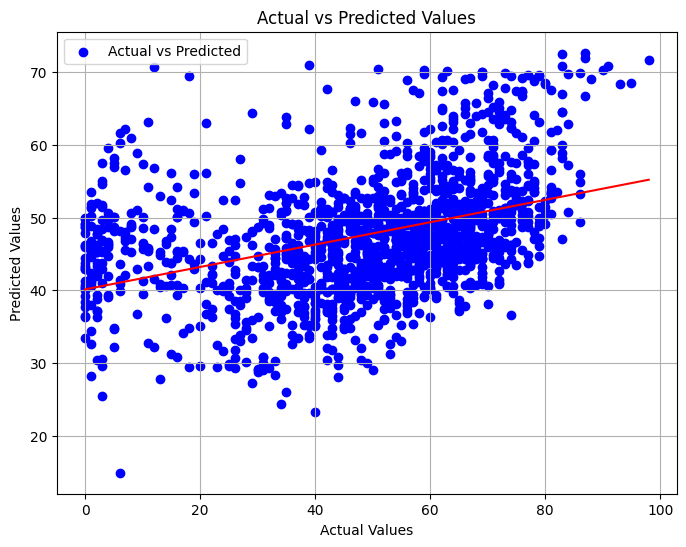

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

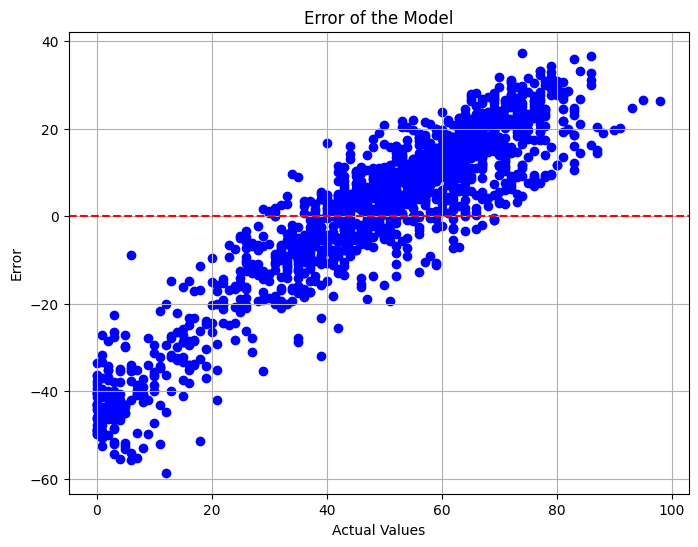

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, error, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Error of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Error')
plt.grid(True)
plt.show()

### NOW WE TRY ADDING LYRICS FEATURES

In [ ]:
X = df_final.drop(columns='track_popularity')
Y = df_final['track_popularity']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=28)

In [ ]:
xgbmodel = XGBRegressor()

In [ ]:
params={'base_score': [0.5], # prediccion inicial
     'booster': ['gbtree','gblinear'], # (gbtree, gblinear, dart)
     'colsample_bylevel': [0.7,1], # ratio de columnas en cada nivel
     'colsample_bytree': [0.7, 1], # ratio de columnas por tree
     'learning_rate': [0.1], # (eta) aportacion de cada arbol al modelo
     'max_depth': [3,4,5,6], # maxima profundidad en cada arbol
     'min_child_weight': [1], # minimo numero samples por hoja
    #'missing': [1], # si queremos reemplazar los missings por un numero
     'n_estimators': [100,250,300,400], # numero de arboles
     'n_jobs': [-1], # trabajos en paralelo
     'random_state': [8], # seed para generar los folds
     'reg_alpha': [0.01, 0.1]} # L1 regularitacion

In [ ]:
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                   param_grid = params,
                   scoring = scoring,
                   cv = 3,
                   n_jobs=-1,
                   refit='neg_mean_squared_error',
                   verbose = 2)

In [ ]:
model_result_xgboost = grid_solver.fit(x_train,y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


In [ ]:
model_result_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, random_state=8, ...)

In [ ]:
model_result_xgboost.best_params_

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 8,
 'reg_alpha': 0.1}

In [ ]:
y_pred=model_result_xgboost.predict(x_test)
print("MSE test:", mean_squared_error(y_test,y_pred), "\nMAE test:", mean_absolute_error(y_test,y_pred), "\nR2 test:", r2_score(y_test,y_pred))

MSE test: 369.35087944710796 
MAE test: 14.891045336948014 
R2 test: 0.2060132658010687


In [ ]:
names.append('XGboost con lyrics')
metricas.append([mean_squared_error(y_test,y_pred), mean_absolute_error(y_test,y_pred), r2_score(y_test,y_pred)])
df_results = pd.DataFrame(metricas, index=names, columns=['MSE test', 'MAE test', 'R2 test'])
df_results

,MSE test,MAE test,R2 test
XGBoost sin lyrics,390.669678,15.538224,0.160185
XGboost con lyrics,369.350879,14.891045,0.206013


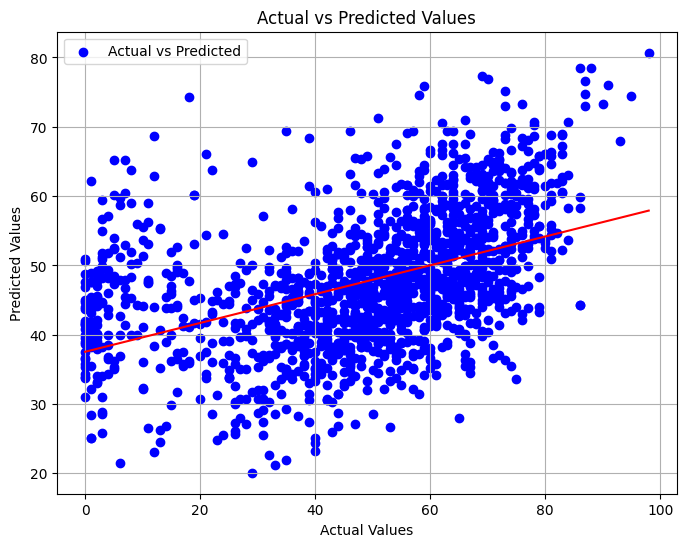

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

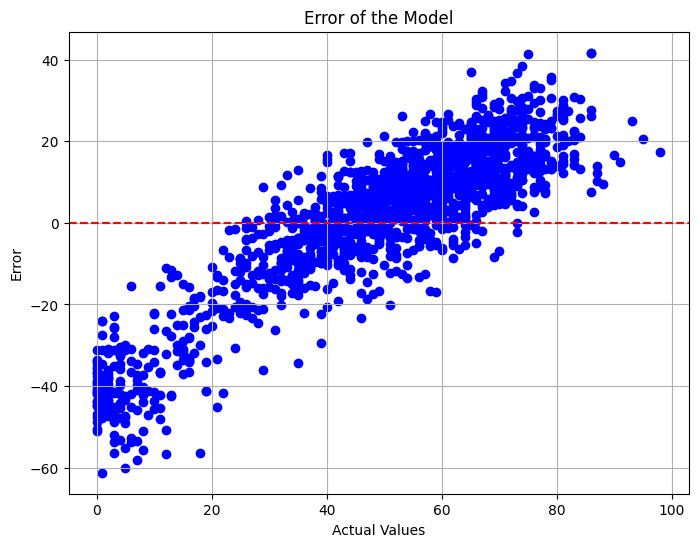

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, error, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Error of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [ ]:
feature_importances = model_result_xgboost.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


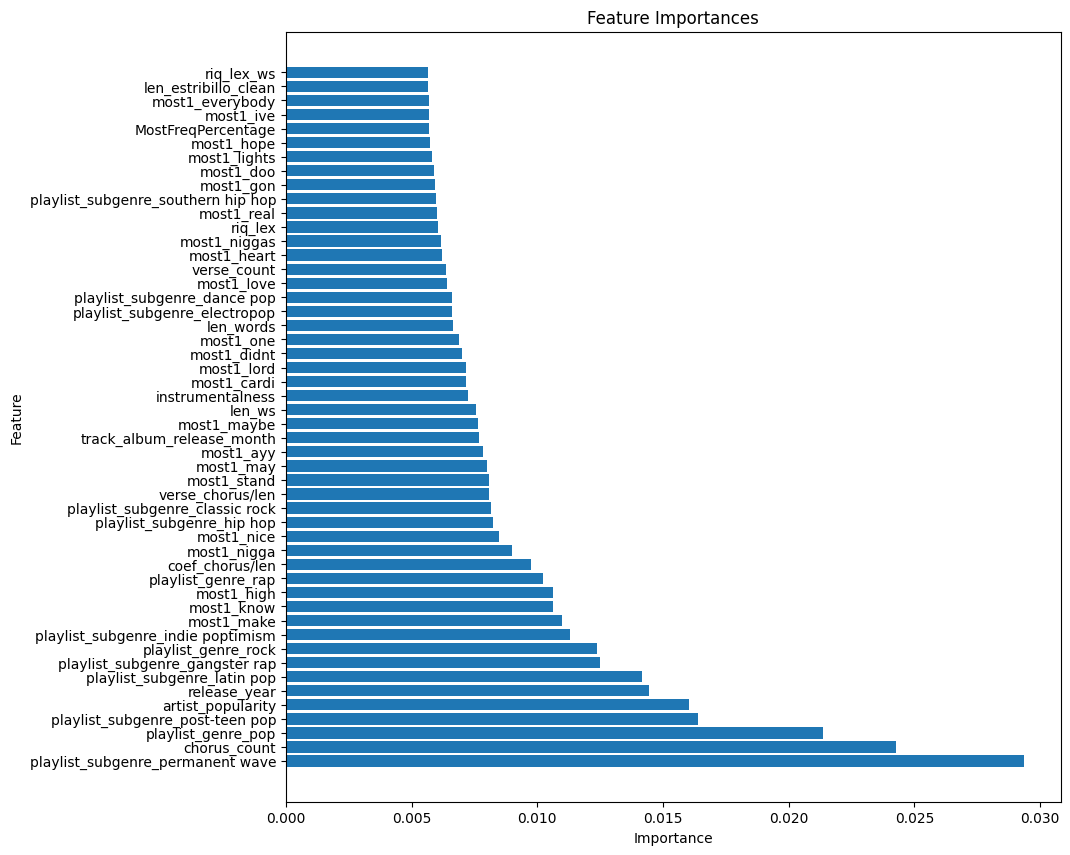

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_df['Feature'][:50], feature_importances_df['Importance'][:50])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
len(feature_importances_df[feature_importances_df['Importance'] > 0])

229

In [ ]:
features_todrop = feature_importances_df[feature_importances_df['Importance'] == 0]['Feature'].values

In [ ]:
len(features_todrop)

1547

### NOW WE TRY WITHOUT COLUMNS WITH FEATURE IMPORTANCE = 0

In [ ]:
X = df_final.drop(features_todrop, axis=1, inplace=True)
X = df_final.drop(columns='track_popularity')
Y = df_final['track_popularity']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=28)

In [ ]:
xgbmodel = XGBRegressor()

In [ ]:
params={'base_score': [0.5], # prediccion inicial
     'booster': ['gbtree','gblinear'], # (gbtree, gblinear, dart)
     'colsample_bylevel': [0.7,1], # ratio de columnas en cada nivel
     'colsample_bytree': [0.7, 1], # ratio de columnas por tree
     'learning_rate': [0.1], # (eta) aportacion de cada arbol al modelo
     'max_depth': [3,4,5,6], # maxima profundidad en cada arbol
     'min_child_weight': [1], # minimo numero samples por hoja
    #'missing': [1], # si queremos reemplazar los missings por un numero
     'n_estimators': [100,250,300,400], # numero de arboles
     'n_jobs': [-1], # trabajos en paralelo
     'random_state': [8], # seed para generar los folds
     'reg_alpha': [0.01, 0.1]} # L1 regularitacion

In [ ]:
scoring = ['neg_mean_squared_error', 'explained_variance', 'r2']
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                   param_grid = params,
                   scoring = scoring,
                   cv = 3,
                   n_jobs=-1,
                   refit='neg_mean_squared_error',
                   verbose = 2)

In [ ]:
model_result_xgboost = grid_solver.fit(x_train,y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


In [ ]:
model_result_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=None, colsample_bytree=0.7,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, random_state=8, ...)

In [ ]:
model_result_xgboost.best_params_

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 8,
 'reg_alpha': 0.1}

In [ ]:
y_pred=model_result_xgboost.predict(x_test)
print("MSE test:", mean_squared_error(y_test,y_pred), "\nMAE test:", mean_absolute_error(y_test,y_pred), "\nR2 test:", r2_score(y_test,y_pred))

MSE test: 368.53925227116804 
MAE test: 14.863184298520313 
R2 test: 0.20775800568574498


In [ ]:
names.append('XGboost tirando columnas con feature importance = 0')
metricas.append([mean_squared_error(y_test,y_pred), mean_absolute_error(y_test,y_pred), r2_score(y_test,y_pred)])
df_results = pd.DataFrame(metricas, index=names, columns=['MSE test', 'MAE test', 'R2 test'])
df_results

,MSE test,MAE test,R2 test
XGBoost sin lyrics,390.669678,15.538224,0.160185
XGboost con lyrics,369.350879,14.891045,0.206013
XGboost tirando columnas con feature importance = 0,368.539252,14.863184,0.207758


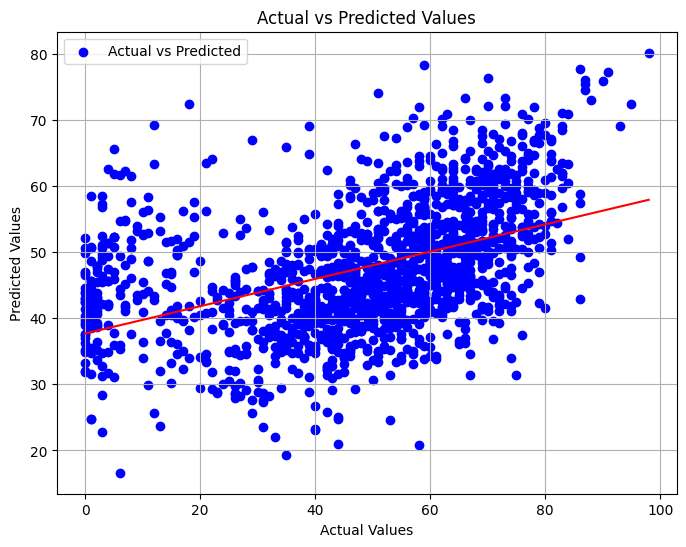

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

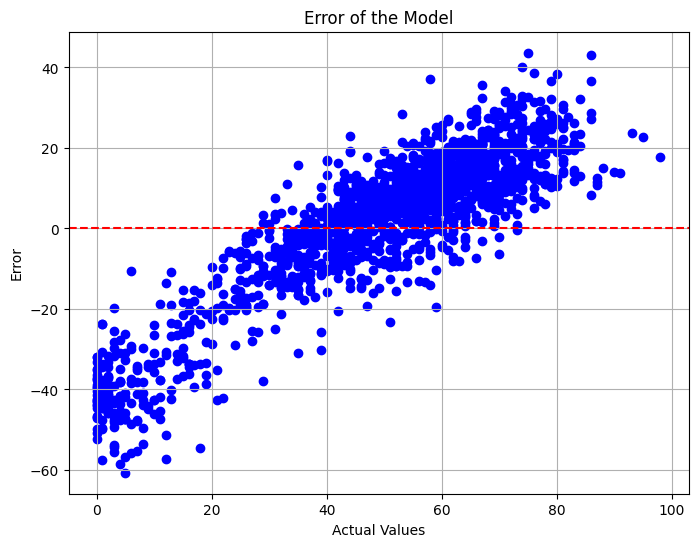

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, error, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Error of the Model')
plt.xlabel('Actual Values')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [ ]:
feature_importances = model_result_xgboost.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


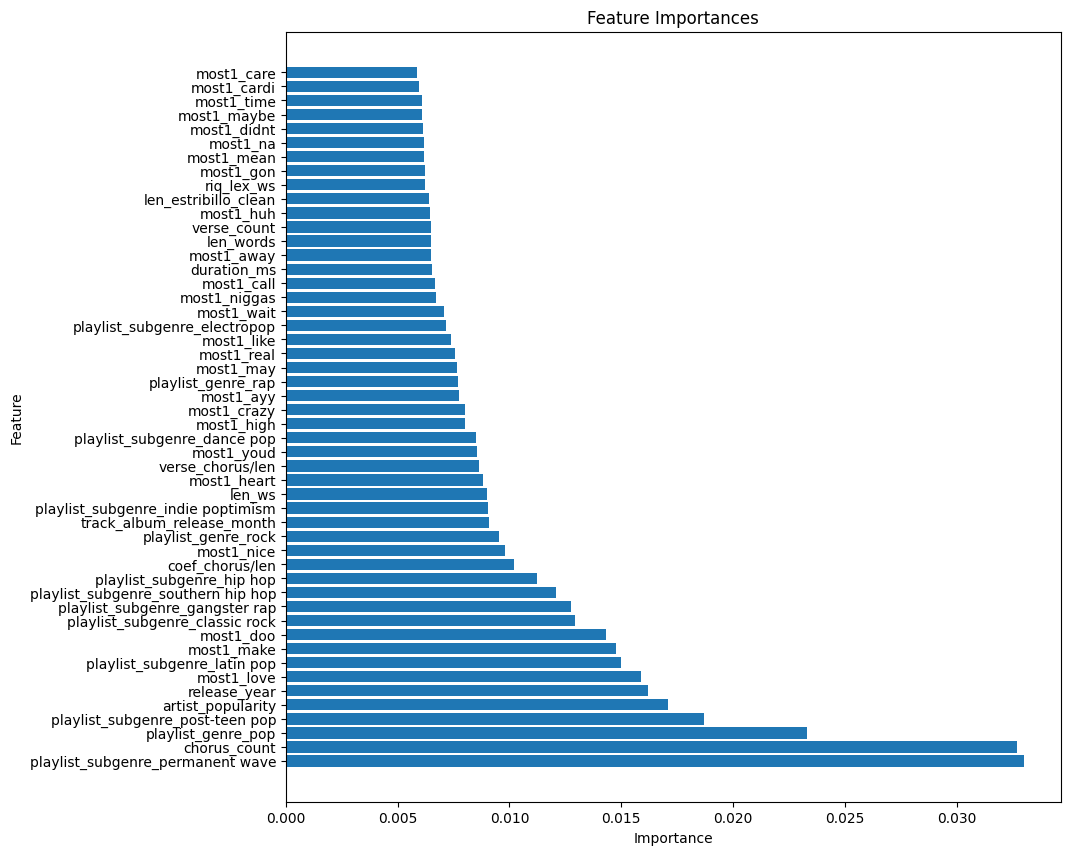

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importances_df['Feature'][:50], feature_importances_df['Importance'][:50])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
len(feature_importances_df[feature_importances_df['Importance'] == 0])

35

In [ ]:
feature_importances_df[feature_importances_df['Importance'] == 0]

,Feature,Importance
203,most1_trying,0.0
208,most1_versa,0.0
218,most1_yet,0.0
217,most1_woman,0.0
227,"topic2_stand,",0.0
207,most1_verona,0.0
225,"topic1_nigga,",0.0
216,most1_woah,0.0
109,most1_head,0.0
53,most1_barbie,0.0


In [ ]:
df_results.to_csv('df_results.csv', index=True)